# **0. Install dependencies**

In [1]:
!pip -q install transformers datasets accelerate evaluate scikit-learn matplotlib pandas numpy

# **1. Setup: seed & device**

In [2]:
import os, random, numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# **2. Load Disaster Tweets (CSV)**

In [3]:
import pandas as pd

KAGGLE_DIR = "/content/sample_data"
train_path = os.path.join(KAGGLE_DIR, "train.csv")
test_path  = os.path.join(KAGGLE_DIR, "test.csv")

assert os.path.exists(train_path), f"Could not find {train_path}. Please upload Kaggle train.csv first."
kaggle_df = pd.read_csv(train_path)

required_cols = {"text", "target"}
assert required_cols.issubset(set(kaggle_df.columns)), f"Unexpected columns in train.csv: {kaggle_df.columns}"

kaggle_df = kaggle_df.dropna(subset=["text"]).reset_index(drop=True)
kaggle_df["label"] = kaggle_df["target"].astype(int)
kaggle_df[["text","label"]].head()

,text,label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# **3. Load HumAID dataset**

In [4]:
!pip -q install -U datasets
!pip -q install "huggingface-hub<1.0,>=0.34.0"

from datasets import load_dataset

humaid = load_dataset(
    "QCRI/HumAID-all",
    verification_mode="no_checks",
    download_mode="reuse_dataset_if_exists"
)

if "validation" in humaid and "dev" not in humaid:
    humaid["dev"] = humaid["validation"]
    del humaid["validation"]

print("HumAID splits:", list(humaid.keys()))
humaid

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


HumAID splits: ['train', 'test', 'dev']


DatasetDict({
    train: Dataset({
        features: ['tweet_text', 'class_label'],
        num_rows: 53531
    })
    test: Dataset({
        features: ['tweet_text', 'class_label'],
        num_rows: 15160
    })
    dev: Dataset({
        features: ['tweet_text', 'class_label'],
        num_rows: 7793
    })
})

# **4. HumAID → Binary label mapping**

In [5]:
NEG_LABELS = {"not_humanitarian", "dont_know_cant_judge"}

def huma_id_to_binary(example):
    y = 0 if example["class_label"] in NEG_LABELS else 1
    return {"text": example["tweet_text"], "label": y}

humaid_bin = humaid.map(huma_id_to_binary, remove_columns=humaid["train"].column_names)

print("HumAID_bin splits:", list(humaid_bin.keys()))
humaid_bin["train"][0]

Map:   0%|          | 0/53531 [00:00<?, ? examples/s]

Map:   0%|          | 0/15160 [00:00<?, ? examples/s]

Map:   0%|          | 0/7793 [00:00<?, ? examples/s]

HumAID_bin splits: ['train', 'test', 'dev']


{'text': 'Powerful Ecuador quake kills at least 235: PORTOVIEJO - Rescuers in Ecuador raced to dig out people trapped un',
 'label': 1}

# **5. Train/Val/Test split for Disaster Tweets**

In [6]:
from sklearn.model_selection import train_test_split

train_df, tmp_df = train_test_split(
    kaggle_df[["text","label"]], test_size=0.2, random_state=42, stratify=kaggle_df["label"]
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.5, random_state=42, stratify=tmp_df["label"]
)

len(train_df), len(val_df), len(test_df)

(6090, 761, 762)

# **6. BERT setup: tokenization, metrics, and training utilities**

In [7]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def to_hf_dataset(df):
    return Dataset.from_pandas(df.reset_index(drop=True))

kaggle_train_ds = to_hf_dataset(train_df)
kaggle_val_ds   = to_hf_dataset(val_df)
kaggle_test_ds  = to_hf_dataset(test_df)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

kaggle_train_tok = kaggle_train_ds.map(tokenize_fn, batched=True)
kaggle_val_tok   = kaggle_val_ds.map(tokenize_fn, batched=True)
kaggle_test_tok  = kaggle_test_ds.map(tokenize_fn, batched=True)

humaid_train_tok = humaid_bin["train"].map(tokenize_fn, batched=True)
humaid_dev_tok   = humaid_bin["dev"].map(tokenize_fn, batched=True)
humaid_test_tok  = humaid_bin["test"].map(tokenize_fn, batched=True)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

def freeze_bert_layers(model, freeze_n_layers: int):
    if freeze_n_layers <= 0:
        return
    for p in model.bert.embeddings.parameters():
        p.requires_grad = False
    for i in range(freeze_n_layers):
        for p in model.bert.encoder.layer[i].parameters():
            p.requires_grad = False

import inspect
import torch
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

def train_bert(train_tok, val_tok, run_name, freeze_n_layers=0, epochs=3, lr=2e-5, bs=16):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    freeze_bert_layers(model, freeze_n_layers)

    sig = inspect.signature(TrainingArguments.__init__).parameters

    args_kwargs = dict(
        output_dir=f"./outputs/{run_name}",
        run_name=run_name,
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        report_to="none",
        seed=42,
        save_strategy="epoch",
    )

    if "eval_strategy" in sig:
        args_kwargs["eval_strategy"] = "epoch"
    else:
        args_kwargs["evaluation_strategy"] = "epoch"

    args = TrainingArguments(**args_kwargs)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/761 [00:00<?, ? examples/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]

Map:   0%|          | 0/53531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7793 [00:00<?, ? examples/s]

Map:   0%|          | 0/15160 [00:00<?, ? examples/s]

# **7. Train BERT models (freeze 0/6/9)**

In [8]:
trainers = {}
for freeze in [0, 6, 9]:
    name = f"bert_kaggle_freeze{freeze}"
    trainers[name] = train_bert(kaggle_train_tok, kaggle_val_tok, run_name=name, freeze_n_layers=freeze, epochs=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1935605800.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.459300,0.388406,0.843627,0.812598
2,0.368000,0.389066,0.842313,0.814241
3,0.277400,0.448644,0.835742,0.813154


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1935605800.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.458600,0.373038,0.846255,0.812800
2,0.389100,0.377941,0.835742,0.810319
3,0.301400,0.392855,0.838371,0.812214


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1935605800.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.448000,0.375232,0.847569,0.818182
2,0.400300,0.394678,0.846255,0.821918
3,0.345100,0.390983,0.843627,0.816641


# **8. Evaluate: Disaster test + HumAID test**

In [9]:
import pandas as pd

def eval_on(trainer, dataset, tag):
    metrics = trainer.evaluate(dataset)
    metrics = {f"{tag}_{k}": v for k,v in metrics.items() if k in ["eval_accuracy","eval_f1","eval_loss"]}
    return metrics

rows = []
for name, tr in trainers.items():
    row = {"model": name}
    row.update(eval_on(tr, kaggle_test_tok, "kaggle_test"))
    row.update(eval_on(tr, humaid_test_tok, "humaid_test"))
    rows.append(row)

results_df = pd.DataFrame(rows)
results_df

,model,kaggle_test_eval_loss,kaggle_test_eval_accuracy,kaggle_test_eval_f1,humaid_test_eval_loss,humaid_test_eval_accuracy,humaid_test_eval_f1
0,bert_kaggle_freeze0,0.401683,0.842520,0.811912,0.437022,0.809037,0.890137
1,bert_kaggle_freeze6,0.385594,0.846457,0.811594,0.455713,0.799208,0.883452
2,bert_kaggle_freeze9,0.382319,0.838583,0.811639,0.389971,0.825066,0.900383


# **9. Interpretability: attention visualization function**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def attention_viz(trainer, text, layer=-1, q_low=5, q_high=95):
    model = trainer.model
    model.eval()

    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, max_length=128
    ).to(model.device)

    with torch.no_grad():
        out = model(**inputs, output_attentions=True)

    att = out.attentions[layer][0]
    att_mean = att.mean(dim=0).cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().tolist())


    special = {"[CLS]", "[SEP]", "[PAD]"}
    keep_idx = [i for i, t in enumerate(tokens) if t not in special]

    att_trim = att_mean[np.ix_(keep_idx, keep_idx)]
    tok_trim = [tokens[i] for i in keep_idx]


    vmin, vmax = np.percentile(att_trim, q_low), np.percentile(att_trim, q_high)


    plt.figure(figsize=(10, 8))
    plt.imshow(att_trim, aspect="auto", vmin=vmin, vmax=vmax)
    plt.xticks(range(len(tok_trim)), tok_trim, rotation=90, fontsize=8)
    plt.yticks(range(len(tok_trim)), tok_trim, fontsize=8)
    plt.title(f"Mean Attention Heatmap (layer {layer}, no special tokens, {q_low}-{q_high} pct)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


    cls_to_tok = att_mean[0]
    cls_trim = cls_to_tok[keep_idx]

    plt.figure(figsize=(10, 3))
    plt.bar(range(len(tok_trim)), cls_trim)
    plt.xticks(range(len(tok_trim)), tok_trim, rotation=90, fontsize=8)
    plt.title("CLS → token attention (mean over heads, no special tokens)")
    plt.tight_layout()
    plt.show()


# **10. Error analysis: confusion matrix & classification report**

BERT freeze0 on Kaggle test
              precision    recall  f1-score   support

           0     0.8492    0.8805    0.8646       435
           1     0.8328    0.7920    0.8119       327

    accuracy                         0.8425       762
   macro avg     0.8410    0.8363    0.8382       762
weighted avg     0.8422    0.8425    0.8420       762



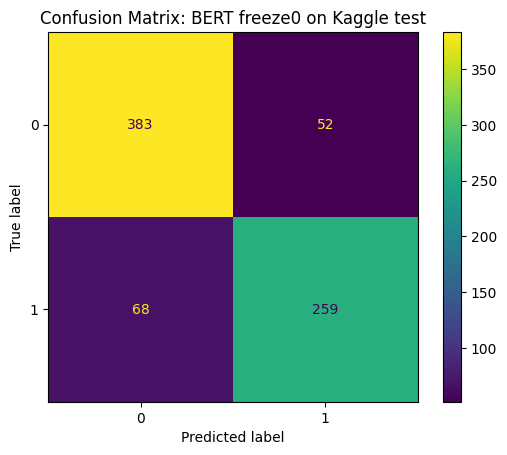

BERT freeze0 on HumAID test (cross-dataset)
              precision    recall  f1-score   support

           0     0.1971    0.4313    0.2706      1245
           1     0.9431    0.8428    0.8901     13915

    accuracy                         0.8090     15160
   macro avg     0.5701    0.6371    0.5804     15160
weighted avg     0.8818    0.8090    0.8393     15160



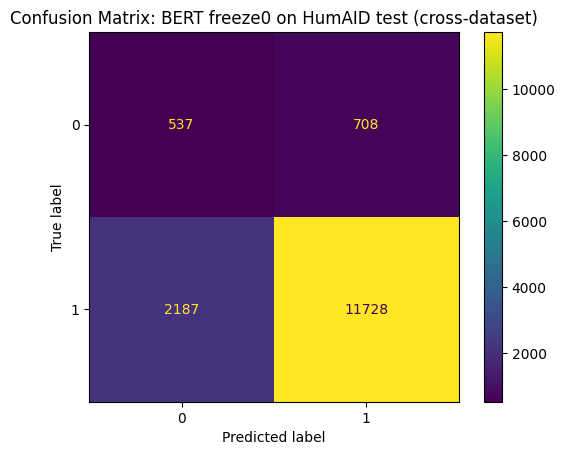

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

def predict_labels(trainer, dataset):
    out = trainer.predict(dataset)
    preds = np.argmax(out.predictions, axis=-1)
    labels = out.label_ids
    return preds, labels

def show_eval(trainer, dataset, title=""):
    preds, labels = predict_labels(trainer, dataset)
    print(title)
    print(classification_report(labels, preds, digits=4))
    disp = ConfusionMatrixDisplay.from_predictions(labels, preds, normalize=None)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

best_tr = trainers["bert_kaggle_freeze0"]
show_eval(best_tr, kaggle_test_tok, "BERT freeze0 on Kaggle test")
show_eval(best_tr, humaid_test_tok, "BERT freeze0 on HumAID test (cross-dataset)")

# **11. Install baseline dependencies**

In [12]:
!pip -q install gensim

# **12. Preprocess for BiLSTM**

In [13]:
import re
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import gensim.downloader as api

def simple_tokenize(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " <url> ", s)
    s = re.sub(r"@\w+", " <user> ", s)
    s = re.sub(r"[^a-z0-9#<>_\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

MIN_FREQ = 2
MAX_VOCAB = 40000

counter = Counter()
for t in train_df["text"].tolist():
    counter.update(simple_tokenize(t))

PAD, UNK = "<pad>", "<unk>"
itos = [PAD, UNK]
for w, c in counter.most_common(MAX_VOCAB):
    if c < MIN_FREQ:
        break
    itos.append(w)
stoi = {w:i for i,w in enumerate(itos)}

def encode(text, max_len=64):
    toks = simple_tokenize(text)[:max_len]
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks]
    return ids

wv = api.load("glove-wiki-gigaword-100")
EMB_DIM = wv.vector_size

emb = np.random.normal(0, 0.02, size=(len(itos), EMB_DIM)).astype(np.float32)
emb[stoi[PAD]] = 0.0

hit = 0
for i, w in enumerate(itos):
    if w in wv:
        emb[i] = wv[w]
        hit += 1
print(f"Vocab={len(itos)}, pretrained hit={hit} ({hit/len(itos):.2%})")

emb_tensor = torch.tensor(emb)

Vocab=5850, pretrained hit=5167 (88.32%)


# **13. BiLSTM baseline**

Epoch 1: train f1=0.6547 acc=0.7401 | val f1=0.7270 acc=0.7898
Epoch 2: train f1=0.7452 acc=0.7977 | val f1=0.7677 acc=0.7845
Epoch 3: train f1=0.7565 acc=0.8053 | val f1=0.7748 acc=0.8121
Epoch 4: train f1=0.7647 acc=0.8130 | val f1=0.7674 acc=0.7976
Epoch 5: train f1=0.7822 acc=0.8258 | val f1=0.7564 acc=0.7884
Epoch 6: train f1=0.7852 acc=0.8292 | val f1=0.7639 acc=0.8108
Epoch 7: train f1=0.7955 acc=0.8360 | val f1=0.7612 acc=0.7963
Epoch 8: train f1=0.8100 acc=0.8470 | val f1=0.7680 acc=0.8095

BiLSTM on Kaggle test: {'loss': 0.4543223418588713, 'acc': 0.8057742782152231, 'f1': 0.7541528239202658}
BiLSTM on HumAID test (cross-dataset): {'loss': 0.6588650345487771, 'acc': 0.641622691292876, 'f1': 0.7679692504804613}

[Kaggle test] classification report
              precision    recall  f1-score   support

           0     0.7947    0.8897    0.8395       435
           1     0.8255    0.6942    0.7542       327

    accuracy                         0.8058       762
   macro avg   

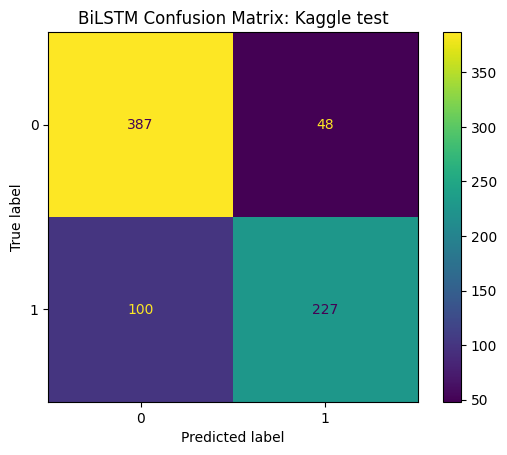


[HumAID test] classification report
              precision    recall  f1-score   support

           0     0.1300    0.5912    0.2132      1245
           1     0.9464    0.6461    0.7680     13915

    accuracy                         0.6416     15160
   macro avg     0.5382    0.6187    0.4906     15160
weighted avg     0.8794    0.6416    0.7224     15160



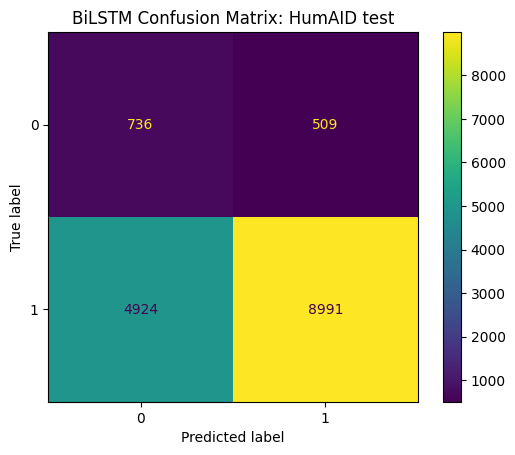

In [14]:
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class TextClsDataset(Dataset):
    def __init__(self, texts, labels, max_len=64):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = encode(self.texts[idx], max_len=self.max_len)
        y = int(self.labels[idx])
        return torch.tensor(ids, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate_pad(batch):
    xs, ys = zip(*batch)
    lens = torch.tensor([len(x) for x in xs], dtype=torch.long)
    maxlen = max(lens).item()
    padded = torch.full((len(xs), maxlen), fill_value=stoi[PAD], dtype=torch.long)
    for i, x in enumerate(xs):
        padded[i, :len(x)] = x
    return padded, lens, torch.stack(ys)

class BiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden=128, dropout=0.3):
        super().__init__()
        vocab_size, emb_dim = embedding_matrix.shape
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.emb.weight.data.copy_(embedding_matrix)
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(
            emb_dim, hidden, batch_first=True, bidirectional=True
        )
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden*2, 2)

    def forward(self, x, lens):
        e = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(e, lens.cpu(), batch_first=True, enforce_sorted=False)
        out, (h, c) = self.lstm(packed)
        h_f = h[-2]
        h_b = h[-1]
        hcat = torch.cat([h_f, h_b], dim=1)
        logits = self.fc(self.drop(hcat))
        return logits

def run_epoch(model, loader, opt=None):
    train = opt is not None
    model.train() if train else model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    ce = nn.CrossEntropyLoss()
    for x, lens, y in loader:
        x, lens, y = x.to(device), lens.to(device), y.to(device)
        if train:
            opt.zero_grad()
        logits = model(x, lens)
        loss = ce(logits, y)
        if train:
            loss.backward()
            opt.step()
        total_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return {
        "loss": total_loss / len(loader.dataset),
        "acc": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds),
        "preds": all_preds,
        "labels": all_labels
    }

MAX_LEN = 64
BS = 64

k_train = TextClsDataset(train_df["text"].tolist(), train_df["label"].tolist(), max_len=MAX_LEN)
k_val   = TextClsDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   max_len=MAX_LEN)
k_test  = TextClsDataset(test_df["text"].tolist(),  test_df["label"].tolist(),  max_len=MAX_LEN)

h_test = TextClsDataset(
    humaid_bin["test"]["text"],
    humaid_bin["test"]["label"],
    max_len=MAX_LEN
)

train_loader = DataLoader(k_train, batch_size=BS, shuffle=True, collate_fn=collate_pad)
val_loader   = DataLoader(k_val,   batch_size=BS, shuffle=False, collate_fn=collate_pad)
test_loader  = DataLoader(k_test,  batch_size=BS, shuffle=False, collate_fn=collate_pad)
humaid_loader= DataLoader(h_test,  batch_size=BS, shuffle=False, collate_fn=collate_pad)

model = BiLSTM(emb_tensor).to(device)
opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-3)

best_f1, best_state = -1, None
EPOCHS = 8
for ep in range(1, EPOCHS+1):
    tr = run_epoch(model, train_loader, opt)
    va = run_epoch(model, val_loader, None)
    print(f"Epoch {ep}: train f1={tr['f1']:.4f} acc={tr['acc']:.4f} | val f1={va['f1']:.4f} acc={va['acc']:.4f}")
    if va["f1"] > best_f1:
        best_f1 = va["f1"]
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

model.load_state_dict(best_state)

te = run_epoch(model, test_loader, None)
ht = run_epoch(model, humaid_loader, None)
print("\nBiLSTM on Kaggle test:", {k: te[k] for k in ["loss","acc","f1"]})
print("BiLSTM on HumAID test (cross-dataset):", {k: ht[k] for k in ["loss","acc","f1"]})

print("\n[Kaggle test] classification report")
print(classification_report(te["labels"], te["preds"], digits=4))
ConfusionMatrixDisplay.from_predictions(te["labels"], te["preds"])
plt.title("BiLSTM Confusion Matrix: Kaggle test")
plt.show()

print("\n[HumAID test] classification report")
print(classification_report(ht["labels"], ht["preds"], digits=4))
ConfusionMatrixDisplay.from_predictions(ht["labels"], ht["preds"])
plt.title("BiLSTM Confusion Matrix: HumAID test")
plt.show()